# Guided lab : Image Classification using CNN

At the end of this tutorial, you would get familiarized with

*   Creating deep networks using Keras
*   Steps necessary in training a neural network
*   Prediction and performance analysis using neural networks

---

# **Colaboratory environment**
By default, Colab notebooks run on CPU.
You can switch your notebook to run with GPU.

In order to obtain access to the GPU, you need to choose the tab Runtime and then select “Change runtime type” as shown in the following figure:

![Changing runtime](https://miro.medium.com/max/747/1*euE7nGZ0uJQcgvkpgvkoQg.png)

When a pop-up window appears select GPU. 

**Ensure “Hardware accelerator” is set to GPU.**

# **Environment set up**
**Keras** is a Python library that provides, in a simple way, the creation of a wide range of Deep Learning models using as backend other libraries such as TensorFlow, Theano or CNTK **(We would use Tensorflow backend)**. 

Keras is used since its learning curve is very smooth compared to others, and at the moment it is one of the popular middleware to implement neural networks.

The developer guides for Keras can be found at: https://keras.io/guides/

In [18]:
from tensorflow import keras

print(keras.__version__)

3.5.0


# **Understanding Data: MNIST Dataset**
The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset. 

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

In Keras, the MNIST dataset is preloaded in the form of four Numpy arrays. x_train and y_train contain the training set, while x_test and y_test contain the test data. The images are encoded as Numpy arrays and their corresponding labels ranging from 0 to 9.

In [19]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_train.ndim)
print(x_train.dtype)

print(x_test.shape)

(60000, 28, 28)
3
uint8
(10000, 28, 28)


## Visualizing the Data

A plot of the first nine images in the dataset is created showing the natural handwritten nature of the images to be classified.

**Let us create a 3*3 subplot to visualize the first 9 images of the dataset.** 

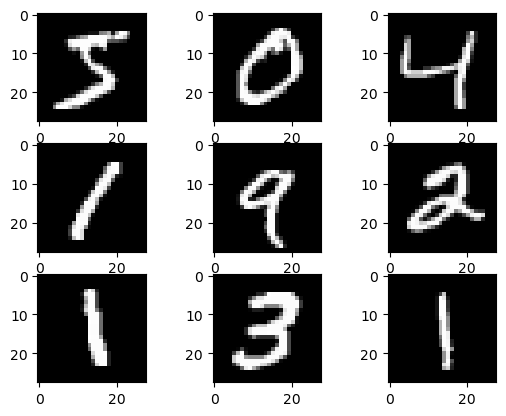

In [20]:
import matplotlib.pyplot as plt

for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

## Data normalization

The pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

**Let us normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1].**

*Hint: 'astype' is a numpy function that could be used to cast the numpy array to a specified type*

In [21]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Preparing data
The images are all pre-aligned (e.g. each image only contains a hand-drawn digit) and they have the same square size of 28×28 pixels. Also, the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a 1D vector data.

*Note that this data preparation is not applicable for all networks*

**Let us reshape the images as a 1D vector.**

In [22]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Preparing labels

The labels for each input data (remember that in our case they are numbers between 0 and 9) indicate which digit represents the image, that is, to which class it is associated. 

In this case, we will represent this label with a vector of 10 positions, where the position corresponding to the digit that represents the image contains a 1 and the remaining positions of the vector contain the value 0. This is known as **one-hot encoding.**

**Let us convert the labels into the equivalent one-hot encoded form.**

*Hint: keras.utils.to_categorical could be used to convert an integer vector to a binary class matrix.*

In [23]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


# **Defining Model**

The Sequential class of the Keras library is a wrapper for the sequential neural network model. In this case, the model in Keras is considered as a sequence of layers and each of them gradually “distills” the input data to obtain the desired output. 

In Keras we can find all the required types of layers that can be easily added to the model through the add() method. 

Below snippet shows a simple network with a single dense layer. 

*Note that the input information has to be defined in the first layer of the model.* 

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(10, input_dim=784))
model.add(Activation('relu'))

The architecture of the model can be checked using the function **summary()** available in the model class. Note that the summary returns the layer information along with the output shape for each layer and the number of parameters that needs to be trained.

In this simple example, it indicates that 7,850 parameters are required (column Param #). In the first layer, for each neuron i (between 0 and 9) we require 784 parameters for the weights wij and therefore 10×784 parameters to store the weights of the 10 neurons. In addition to that 10 additional parameters for the 10 bj biases corresponding to each one of them.

The non-trainable parameters of a model are those that will not be updating and optimized during training, and that have to be defined a priori, or passed as inputs. 

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling models

Before training a model, we need to configure the learning process, which is done via the compile method. It receives three arguments:

*   Loss function
*   Optimizer
*   Metrics

**Hint: Learn the commonly used loss functions and optimizers available in Keras documentation.**

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics = ['accuracy'])

## Training models

Keras models are trained on Numpy arrays of input data and labels. For training a model, we will typically use the fit function.

In [27]:
history = model.fit(x_train, y_train, batch_size=1024, epochs=5)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2327 - loss: 2.6813 
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3271 - loss: 1.7804
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1889 - loss: 1.6502
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4386 - loss: 1.3343
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3563 - loss: nan   


## History Callback

A callback is a set of functions to be applied at given stages of the training procedure. It can be used to get a view on internal states and statistics of the model during training. There are several callbacks are available in Keras and they are passed as a list of callbacks to the .fit() method.

The History object gets returned by the fit method of models and is automatically applied to every Keras model.

In [28]:
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


In [29]:
print(history.history['loss']) # returns the loss value at the end of each epoch
print(history.history['accuracy']) # returns the accuracy at the end of each epoch

[2.01804780960083, 1.828766942024231, 1.5772137641906738, 1.2921231985092163, nan]
[0.3315666615962982, 0.19065000116825104, 0.2420833259820938, 0.5073833465576172, 0.19466666877269745]


**Let us plot the loss values and the accuracy values as a 2 x 1 plot.**

Note that the loss term decreases and the accuracy increases with respect to the epochs.

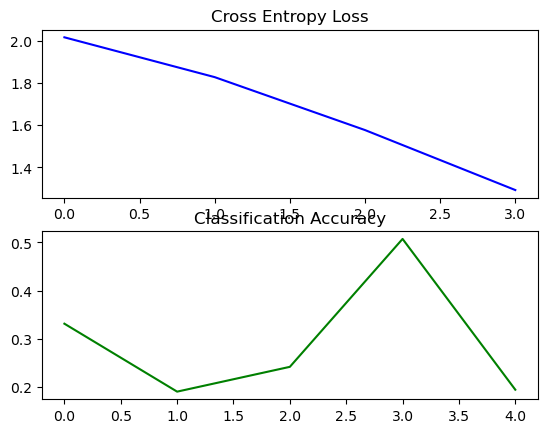

In [30]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.show()

# **Model evaluation**

## Accuracy

After training the model, the network has to be evaluated with new test data. This can be achieved by using the evaluate() method.

**Let us print the test accuracy of the network.**

In [31]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.0924 - loss: nan
Test loss: nan
Test accuracy: 0.09799999743700027


## Confusion matrix

Note that accuracy is the ratio between the correct predictions that the model has made over the total predictions regardless of what category it is. However, it is necessary to delve a little more and take into account the types of correct and incorrect predictions made by the model in each of its categories.

For this purpose, a confusion matrix is used. It is a table with rows and columns that count the predictions in comparison with the real values. This is used to better understand how well the model behaves and it is very useful to show explicitly when one class is confused with another.

**Hint:**
1.   predict() is used to predict the output for the input samples.
2.   confusion_matrix is available in sklearn.metrics

In [32]:
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


It has to be noted that the predictions is the probability of the input belonging to any one of the class.

In [33]:
print(predictions[0])

[nan nan nan nan nan nan nan nan nan nan]


**Now, let us convert the probability distribution to get single output for each input. For this, we would take the maximum probability score.**

In [34]:
import numpy as np
predictions = np.argmax(predictions, axis=1)

In [35]:
from sklearn.metrics import confusion_matrix
gt = np.argmax(y_test, axis=1)

**Now, we will use the confusion matrix function to get the table for all the 10 classes.**

In [36]:
confusion_matrix(gt, predictions)

array([[ 980,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1135,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1032,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1010,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 982,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 892,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 958,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1028,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 974,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1009,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

# **Defining different models**

In the previous example, we designed a neural network with just dense layers. But in practice, the deep networks are more wider and deeper.

When we define a model, the shallow layers learn the low level features such as edges and as the networks go deeper, the network learns the high level features. 
The model, in general, has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

**Define the following model:** 

**For the convolutional front-end, start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. Use the input as (28,28,1) instead of (784,). The filter maps can then be flattened to provide features to the classifier. Use a dense layer with 100 units before the classification layer (which is also a dense layer with softmax activation).**

*Hint: Conv2D, MaxPooling2D, Flatten, Dense and other layers can be obtained by importing keras.layer*

In [48]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Let us check the architecture using summary().**

In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the model.**

In [55]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

**Reshape the input of the mnist dataset to the new input dimensions (28, 28, 1).**

In [56]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_train.ndim)
print(x_train.dtype)
print(x_test.shape)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print('After reshaping:')

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)
print(x_train.ndim)
print(x_train.dtype)
print(x_test.shape)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
3
uint8
(10000, 28, 28)
After reshaping:
(60000, 28, 28, 1)
4
float32
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


**Train the model for 10 epochs with a batch size of 100.**

In [57]:
history = model.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=0.1)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7834 - loss: 0.8319 - val_accuracy: 0.9460 - val_loss: 0.2102
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9324 - loss: 0.2439 - val_accuracy: 0.9600 - val_loss: 0.1605
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9494 - loss: 0.1836 - val_accuracy: 0.9665 - val_loss: 0.1309
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9574 - loss: 0.1549 - val_accuracy: 0.9695 - val_loss: 0.1171
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9627 - loss: 0.1336 - val_accuracy: 0.9747 - val_loss: 0.1020
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9671 - loss: 0.1190 - val_accuracy: 0.9758 - val_loss: 0.0952
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9706 - loss: 0.1099 - val_accuracy: 0.9778 - val_loss: 0.0865
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9732 - loss: 0.0985 - val_accu

In [59]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


**Plot the loss function and the accuracy curves as before.**

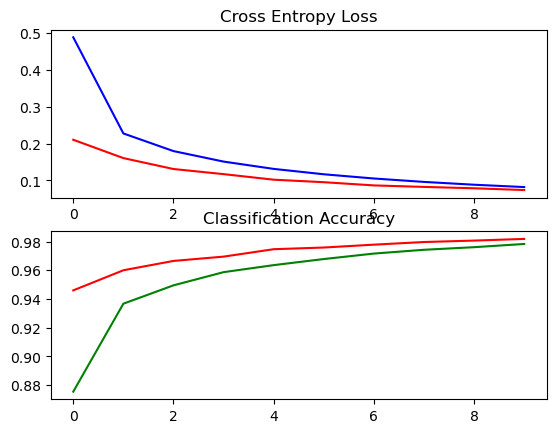

In [60]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')
plt.show()

**Print the loss and the test accuracy.**

In [61]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9729 - loss: 0.0966
Test loss: 0.08242794126272202
Test accuracy: 0.9761000275611877


**Print the confusion matrix for the test samples.**

In [62]:
import numpy as np
predictions = model.predict(x_test)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10)


In [63]:
confusion_matrix(gt, predictions)

array([[ 970,    0,    1,    1,    0,    1,    3,    2,    2,    0],
       [   0, 1126,    1,    3,    0,    0,    3,    0,    2,    0],
       [   5,    5,  998,    6,    4,    0,    3,    6,    4,    1],
       [   0,    0,    1,  996,    0,    5,    0,    1,    2,    5],
       [   1,    0,    2,    0,  960,    0,    2,    1,    2,   14],
       [   2,    0,    0,    4,    0,  881,    3,    0,    2,    0],
       [   8,    3,    1,    1,    3,    6,  930,    2,    4,    0],
       [   0,    3,   15,    7,    1,    0,    0,  987,    4,   11],
       [   5,    0,    1,   10,    3,    4,    2,    1,  942,    6],
       [   6,    6,    1,    7,    7,    5,    0,    4,    2,  971]])

# **Clearing models**
clear_session() is useful when you're creating multiple models in succession, such as during hyperparameter search or cross-validation. Each model that is trained adds nodes (potentially numbering in the thousands) to the graph. Clearing the session removes all the nodes left over from previous models, freeing memory and preventing slowdown.

In [64]:
from keras.backend import clear_session
clear_session()

### Thank you for following this tutorial !